# Naïve Bayes Algorithm

## Overview

The Naïve Bayes algorithm is a probabilistic machine learning algorithm based on Bayes' Theorem. It assumes that all features are independent of each other given the class label, which is a strong assumption, hence the term "naïve". It is commonly used for classification tasks such as spam detection, text classification, and sentiment analysis.

### How Naïve Bayes Works

1. **Training Phase**:
   - The algorithm calculates the prior probabilities of each class from the training data.
   - It computes the likelihood of each feature given each class. For continuous features, it assumes a normal distribution and computes the mean and variance for each feature per class.

2. **Prediction Phase**:
   - For a given test data point, the algorithm calculates the posterior probability for each class using Bayes' Theorem
   - The class with the highest posterior probability is chosen as the predicted class for the test point.

### Key Points

- The "naïve" assumption of independence between features simplifies the computation and makes the algorithm fast and efficient.
- Despite its simplicity, Naïve Bayes often performs surprisingly well and is particularly suited for high-dimensional data.
- It works well with small datasets and can handle both continuous and discrete data.

### Implementation Objective

In this notebook, we will implement the Naïve Bayes algorithm from scratch using Python. We will test our implementation on a dataset and evaluate its performance using metrics such as confusion matrix, accuracy, recall, precision, and F1-score.


### Importing necessary libraries

In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Naive Bayes algorithm implementation

In [60]:
class NaiveBayes:
    def __init__(self, epsilon=1e-9, distribution='gaussian', smoothing=1.0, criterion='log_likelihood'):
        """
        Initialize the Naive Bayes model.

        Parameters:
        - epsilon: Small value to avoid division by zero.
        - distribution: Type of distribution ('gaussian', 'bernoulli', 'multinomial').
        - smoothing: Smoothing factor (used for 'bernoulli' and 'multinomial').
        - criterion: Criterion for probability calculation ('log_likelihood', 'gini', 'entropy').
        """
        self.epsilon = epsilon
        self.distribution = distribution
        self.smoothing = smoothing
        self.criterion = criterion

    def fit(self, X, y):
        """
        Fit the model to the training data.

        Parameters:
        - X: Input feature dataset.
        - y: Corresponding output labels.
        """
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Initialize parameters for each class
        if self.distribution == 'gaussian':
            self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
            self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        elif self.distribution in ['bernoulli', 'multinomial']:
            self._feature_probs = np.zeros((n_classes, n_features), dtype=np.float64)
        
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            if self.distribution == 'gaussian':
                self._mean[idx, :] = X_c.mean(axis=0)
                self._var[idx, :] = X_c.var(axis=0) + self.epsilon  # Add epsilon to avoid division by zero
            elif self.distribution == 'bernoulli':
                # Bernoulli: Calculate the probability of each feature being 1
                self._feature_probs[idx, :] = (np.sum(X_c, axis=0) + self.smoothing) / (X_c.shape[0] + 2 * self.smoothing)
            elif self.distribution == 'multinomial':
                # Multinomial: Calculate the frequency of each feature value
                self._feature_probs[idx, :] = (np.sum(X_c, axis=0) + self.smoothing) / (X_c.sum() + self.smoothing * n_features)

    def predict(self, X):
        """
        Perform prediction on the input dataset X.

        Parameters:
        - X: Input dataset for prediction.

        Returns:
        - y_pred: Predictions for the input data.
        """
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        """
        Predict the label for a single input data point.

        Parameters:
        - x: Input data point.

        Returns:
        - Predicted label for the input point.
        """
        posteriors = []

        # Calculate the posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            if self.criterion == 'log_likelihood':
                if self.distribution == 'gaussian':
                    posterior = np.sum(np.log(self._pdf_gaussian(idx, x) + self.epsilon))  # Avoid log(0) by adding epsilon
                elif self.distribution == 'bernoulli':
                    # Clip probabilities to avoid log(0)
                    probs = np.clip(self._feature_probs[idx, :], self.epsilon, 1 - self.epsilon)
                    posterior = np.sum(
                        x * np.log(probs) + 
                        (1 - x) * np.log(1 - probs)
                    )
                elif self.distribution == 'multinomial':
                    # Clip probabilities to avoid log(0)
                    probs = np.clip(self._feature_probs[idx, :], self.epsilon, 1 - self.epsilon)
                    posterior = np.sum(x * np.log(probs))
                else:
                    raise ValueError(f"Unsupported distribution for criterion 'log_likelihood': {self.distribution}")
            elif self.criterion == 'gini':
                if self.distribution == 'gaussian':
                    posterior = 1 - np.sum((self._pdf_gaussian(idx, x) ** 2))
                else:
                    raise ValueError(f"Gini criterion not supported for {self.distribution}")
            elif self.criterion == 'entropy':
                if self.distribution == 'gaussian':
                    posterior = -np.sum(self._pdf_gaussian(idx, x) * np.log(self._pdf_gaussian(idx, x) + self.epsilon))
                else:
                    raise ValueError(f"Entropy criterion not supported for {self.distribution}")
            else:
                raise ValueError(f"Unsupported criterion: {self.criterion}")
            
            posterior = prior + posterior
            posteriors.append(posterior)

        # Return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf_gaussian(self, class_idx, x):
        """
        Calculate the probability density function for Gaussian distribution.

        Parameters:
        - class_idx: Index of the class.
        - x: Input data point.

        Returns:
        - Probability density value.
        """
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

### Evaluation function for Naive Bayes


In [61]:
def evaluate_nb(X_train, X_test, y_train, y_test, distribution='gaussian', smoothing=1.0, criterion='log_likelihood'):
    # Initialize and train the Naive Bayes model with specified parameters
    nb = NaiveBayes(distribution=distribution, smoothing=smoothing, criterion=criterion)
    nb.fit(X_train, y_train)

    # Predict on the test set
    predictions = nb.predict(X_test)

    # Calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    classes = np.unique(y_test)

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix - Naive Bayes")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate ROC-AUC score for binary classification
    if len(classes) == 2:
        roc_auc = roc_auc_score(y_test, predictions)
        print(f'ROC AUC Score: {roc_auc:.2f}')

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predictions)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC AUC Score and ROC Curve are not applicable for multiclass classification.")

### Load All Datasets

#### Iris Dataset

In [62]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris['class'] = iris['class'].astype('category').cat.codes
X_iris = iris.iloc[:, :-1].values
y_iris = iris.iloc[:, -1].values

#### Penguins Dataset


In [63]:
penguins = sns.load_dataset('penguins').dropna()
penguins['species'] = penguins['species'].astype('category').cat.codes
penguins['island'] = penguins['island'].astype('category').cat.codes
penguins['sex'] = penguins['sex'].astype('category').cat.codes
X_penguins = penguins.drop('species', axis=1).values
y_penguins = penguins['species'].values

#### Titanic Dataset


In [64]:
# Carregar conjunto de dados Titanic
titanic = sns.load_dataset('titanic')

# Preencher valores faltantes sem usar inplace=True
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
titanic = titanic.dropna(subset=['embark_town', 'sex', 'fare', 'class'])

# Transformar características categóricas em numéricas
titanic['sex'] = titanic['sex'].astype('category').cat.codes
titanic['embarked'] = titanic['embarked'].astype('category').cat.codes
titanic['class'] = titanic['class'].astype('category').cat.codes

# Separar características e rótulos
X_titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].values
y_titanic = titanic['survived'].values

#### Census Income Dataset


In [65]:
census = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
census.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
for column in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']:
    census[column] = census[column].astype('category').cat.codes
X_census = census.drop('income', axis=1).values
y_census = census['income'].values

### Test Naive Bayes on all datasets


Testing Naive Bayes on Iris dataset with distribution=gaussian, smoothing=1.0, criterion=log_likelihood
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


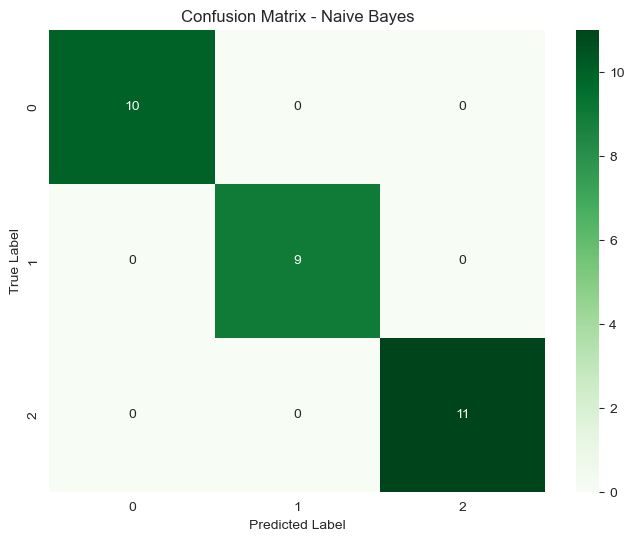

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing Naive Bayes on Penguins dataset with distribution=gaussian, smoothing=1.0, criterion=log_likelihood
Accuracy: 0.90
Precision: 0.93
Recall: 0.90
F1 Score: 0.90


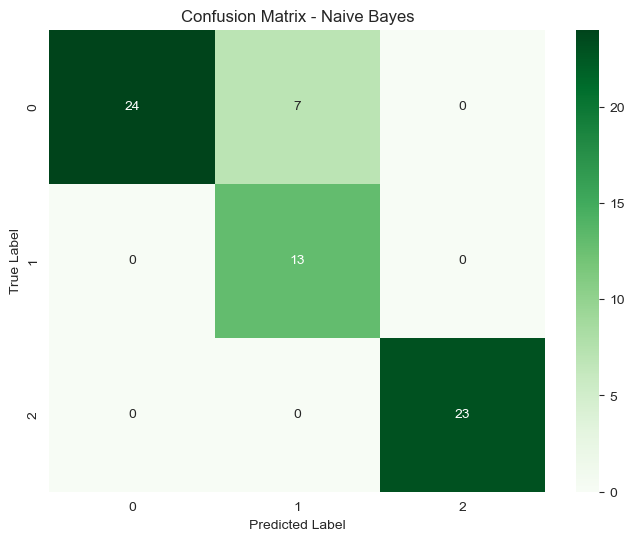

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing Naive Bayes on Titanic dataset with distribution=bernoulli, smoothing=1.0, criterion=log_likelihood
Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1 Score: 0.79


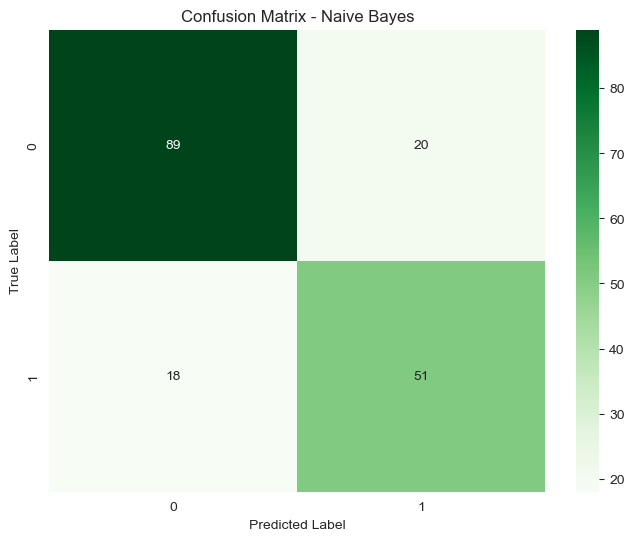

ROC AUC Score: 0.78


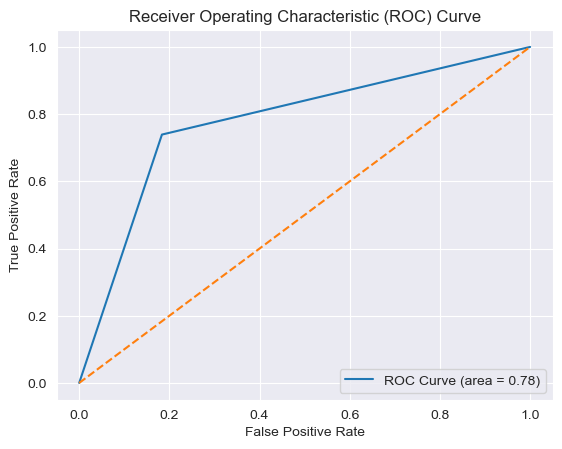

Testing Naive Bayes on Census dataset with distribution=multinomial, smoothing=1.0, criterion=log_likelihood
Accuracy: 0.78
Precision: 0.76
Recall: 0.78
F1 Score: 0.75


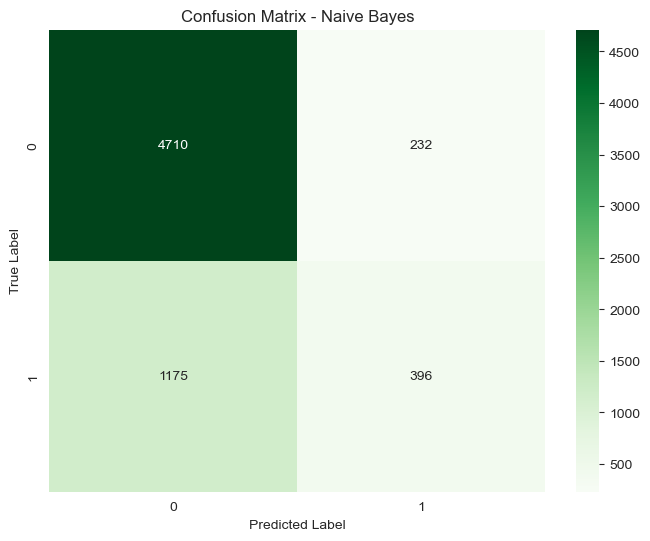

ROC AUC Score: 0.60


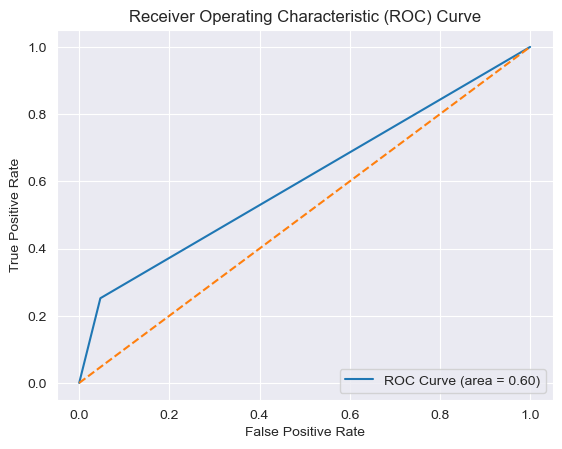

In [66]:
datasets = {
    'Iris': (X_iris, y_iris, 'gaussian', 1.0, 'log_likelihood'),   
    # 'gaussian' distribution is chosen for the Iris dataset because all the features 
    # (sepal length, sepal width, petal length, petal width) are continuous numeric variables.
    # Smoothing is set to 1.0 as a default precaution, but it is not typically used for Gaussian.
    # The 'log_likelihood' criterion is standard for continuous data with Gaussian distribution.

    'Penguins': (X_penguins, y_penguins, 'gaussian', 1.0, 'log_likelihood'),  
    # 'gaussian' distribution is selected because the features of the Penguins dataset 
    # (e.g., bill length, flipper length, body mass) are continuous numeric variables.
    # Smoothing of 1.0 helps avoid any numerical instabilities.
    # The 'log_likelihood' criterion is used for calculating the likelihood of the Gaussian distribution.

    'Titanic': (X_titanic, y_titanic, 'bernoulli', 1.0, 'log_likelihood'),  
    # 'bernoulli' distribution is appropriate for the Titanic dataset because many features 
    # (e.g., sex, survived) are binary (0 or 1). The Bernoulli distribution handles binary features well.
    # Smoothing is set to 1.0 to handle cases where a particular feature-class combination does not appear in the training data.
    # The 'log_likelihood' criterion is used to compute the log-probability for binary features.

    'Census': (X_census, y_census, 'multinomial', 1.0, 'log_likelihood')  
    # 'multinomial' distribution is suitable for the Census dataset because it contains categorical features 
    # (e.g., workclass, education, marital-status) which have been encoded as integers. The multinomial distribution models the counts of categorical variables.
    # Smoothing is set to 1.0 to ensure non-zero probabilities for all categories.
    # The 'log_likelihood' criterion is standard for calculating probabilities in a multinomial Naive Bayes model.
}


for name, (X, y, distribution, smoothing, criterion) in datasets.items():
    print(f"Testing Naive Bayes on {name} dataset with distribution={distribution}, smoothing={smoothing}, criterion={criterion}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    evaluate_nb(X_train, X_test, y_train, y_test, distribution=distribution, smoothing=smoothing, criterion=criterion)